# DSA210 Project – Apple vs Samsung Stock Analysis (2019–2024)

This notebook analyzes how the COVID-19 pandemic influenced the stock price behavior 
of two major technology companies: **Apple** and **Samsung**. By combining daily stock prices 
with global daily COVID-19 case counts, this study investigates whether external global shocks 
can affect investor behavior, market volatility, and company growth patterns.

This submission corresponds to the **28 November milestone**, which includes:
- Data collection  
- Data cleaning and preprocessing  
- Exploratory data analysis (EDA)  
- Statistical hypothesis testing  


## Research Questions

- How did Apple and Samsung stock prices change between 2019 and 2024?
- Did both companies show similar growth patterns before and after the COVID-19 pandemic?
- Is there a relationship between daily COVID-19 cases and the stock prices of Apple and Samsung?
- How can the average prices and returns of Apple and Samsung be compared over time?
- Which company adapted more quickly to the market changes caused by the pandemic?

## Hypotheses

- **H1:** In the early pandemic months, Apple's stock price increased faster than Samsung's.
- **H2:** Samsung reacts more slowly to market shocks, lagging behind Apple's price growth.
- **H3:** Global COVID-19 daily case counts are positively correlated with Apple’s stock price.
- **H4:** After 2021, Samsung exhibits higher volatility compared to Apple.
- **H5:** Apple outperforms Samsung in terms of monthly average returns.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr

plt.rcParams["figure.figsize"] = (12, 4)
sns.set(style="whitegrid")

In [26]:
import os
import pandas as pd
import numpy as np

DATA_DIR = os.getcwd()  # notebook'un çalıştığı klasör
print("Working directory:", DATA_DIR)
print("Files:", [f for f in os.listdir(DATA_DIR) if f.endswith(".csv")])


Working directory: /Users/aysenurucar/Downloads
Files: ['corona.csv', 'apple.csv', 'samsung.csv']


## 1. Data Collection

In this section, Apple, Samsung, and COVID-19 datasets are loaded and merged into a single
dataframe using the `Date` column.


In [14]:
# Load CSV datasets (paths for this environment)
apple = pd.read_csv("apple.csv")
samsung = pd.read_csv("samsung.csv")
covid = pd.read_csv("corona.csv")


# Automatically detect Samsung price column
possible_price_cols = ["Close", "Price", "Adj Close", "Adj_Close", "Closing Price"]
samsung_price_col = None

for col in possible_price_cols:
    if col in samsung.columns:
        samsung_price_col = col
        break

print("Samsung price column found:", samsung_price_col)

Samsung price column found: Price


In [27]:
# Fix date formats (robust)
apple["Date"] = pd.to_datetime(apple["Date"], dayfirst=True, errors="coerce")
samsung["Date"] = pd.to_datetime(samsung["Date"], dayfirst=True, errors="coerce")
covid["Date"] = pd.to_datetime(covid["Date"], dayfirst=True, errors="coerce")

# Merge datasets
df = apple.merge(samsung, on="Date", how="inner")
df = df.merge(covid, on="Date", how="left")

# Rename columns consistently
df = df.rename(columns={
    "Close": "Apple_Price",
    samsung_price_col: "Samsung_Price",
    "New cases": "Covid_Cases"
})

df.head()

,Unnamed: 0,Date,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,...,Deaths,Recovered,Active,Covid_Cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
0,0,2024-02-02,2.079,NaN,72.28,NaN,3.8215,NaN,"43,194.70",42650.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2024-02-01,2.050,161340.0,73.82,577940.0,3.8535,NaN,"43,081.40",47690.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22,2024-01-02,2.568,132450.0,70.38,330990.0,3.8805,NaN,"44,943.70",97840.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,35,2023-12-12,2.311,223460.0,68.61,324530.0,3.7875,69520.0,"41,487.00",57040.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36,2023-12-11,2.350,144300.0,71.32,274410.0,3.7805,66610.0,"41,256.10",105190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Cleaning & Preparation

The following cleaning steps are applied:
- Convert price and COVID-19 case values into numeric format  
- Remove commas from COVID case values  
- Prepare variables for analysis  


In [28]:
# Clean numeric columns
for col in ["Apple_Price", "Samsung_Price", "Covid_Cases"]:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(",", "")
        .str.replace(" ", "")
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

df.describe()

,Unnamed: 0,Date,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Vol.,Platinum_Vol.,...,Deaths,Recovered,Active,Covid_Cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries
count,377.000000,377,377.000000,374.000000,377.000000,3.690000e+02,377.000000,369.000000,3.770000e+02,207.000000,...,42.000000,4.200000e+01,4.200000e+01,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,621.217507,2021-08-02 03:03:20.530504192,3.511549,157529.197861,67.424005,4.715363e+05,3.542627,38211.300813,5.483541e+07,8596.570048,...,227245.285714,1.876132e+06,2.033232e+06,85237.071429,3549.452381,52735.404762,4.899524,36.801429,18.908333,145.000000
min,0.000000,2019-02-04 00:00:00,1.552000,42490.000000,19.780000,9.522000e+04,2.195500,30.000000,2.600000e+02,90.000000,...,426.000000,6.040000e+02,1.885700e+04,1886.000000,5.000000,145.000000,2.060000,3.040000,6.360000,25.000000
25%,313.000000,2020-06-04 00:00:00,2.352000,117852.500000,53.250000,3.412300e+05,2.865500,290.000000,7.869000e+04,535.000000,...,3585.750000,5.592525e+04,4.473600e+04,3960.000000,130.000000,2601.500000,3.460000,24.042500,8.442500,95.250000
50%,621.000000,2021-08-03 00:00:00,2.731000,148925.000000,69.090000,4.134100e+05,3.646000,34750.000000,2.274900e+05,3520.000000,...,255722.500000,1.148340e+06,2.227252e+06,85200.000000,4799.500000,35583.500000,5.520000,43.375000,13.645000,186.000000
75%,907.000000,2022-11-02 00:00:00,4.059000,189852.500000,80.710000,5.731700e+05,4.118000,71340.000000,6.011600e+05,15840.000000,...,404734.000000,3.166489e+06,3.470320e+06,126288.250000,5445.750000,78695.750000,5.955000,50.605000,23.292500,187.000000
max,1242.000000,2024-02-02 00:00:00,9.322000,381970.000000,123.700000,1.770000e+06,4.937500,160250.000000,3.620000e+09,33150.000000,...,560142.000000,6.804254e+06,5.141244e+06,232577.000000,7629.000000,284394.000000,7.150000,54.410000,70.530000,187.000000
std,349.682638,NaN,1.818072,54574.041708,20.977625,1.949342e+05,0.701302,39865.301600,3.632267e+08,9016.865499,...,205491.722365,2.184772e+06,1.797024e+06,72571.691503,2583.369384,60788.589936,1.605712,16.570378,14.078872,61.802597


## 3. Exploratory Data Analysis (EDA)

This section includes:
- Stock price trends  
- COVID-19 global case trends  
- Correlation analysis  
- Daily return distributions  


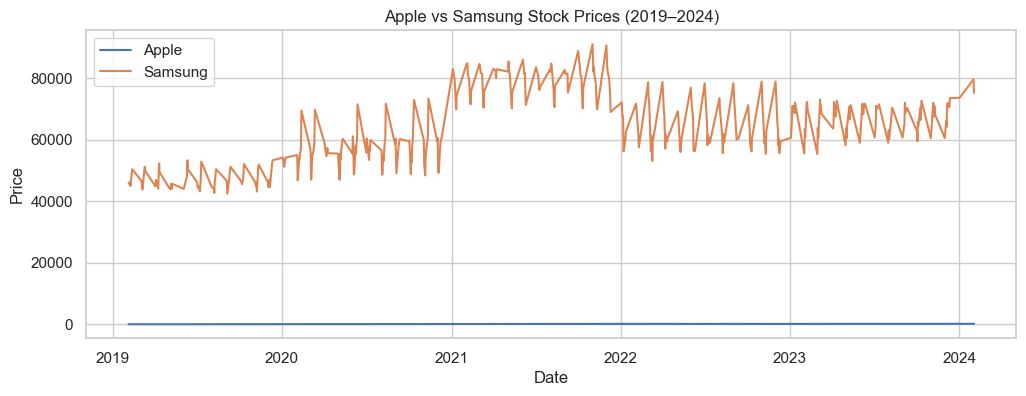

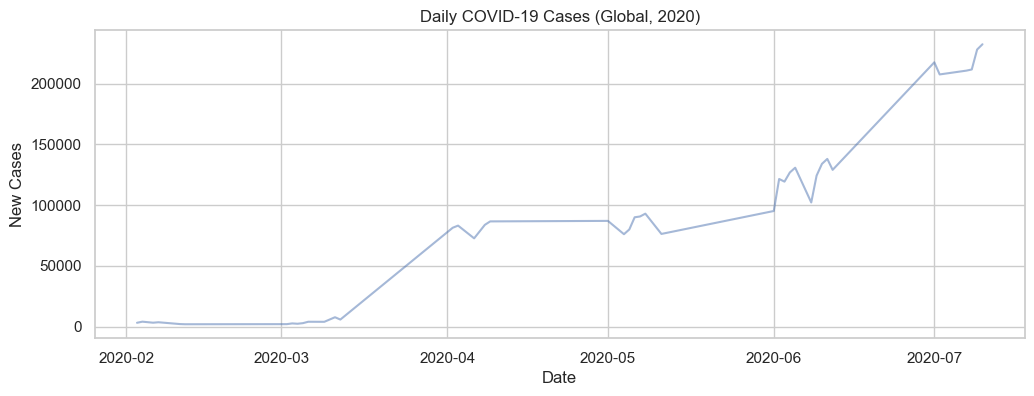

In [29]:
# Apple vs Samsung stock prices
plt.plot(df["Date"], df["Apple_Price"], label="Apple")
plt.plot(df["Date"], df["Samsung_Price"], label="Samsung")
plt.title("Apple vs Samsung Stock Prices (2019–2024)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# COVID-19 daily cases
covid_part = df.dropna(subset=["Covid_Cases"])
plt.plot(covid_part["Date"], covid_part["Covid_Cases"], alpha=0.5)
plt.title("Daily COVID-19 Cases (Global, 2020)")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.show()

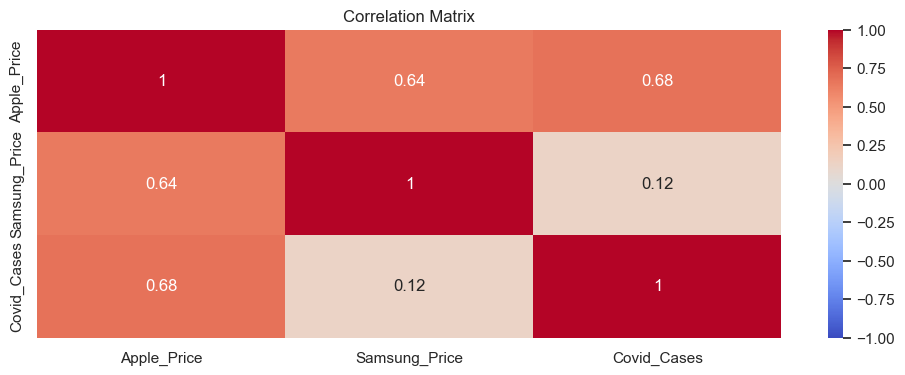

,Apple_Price,Samsung_Price,Covid_Cases
Apple_Price,1.000000,0.644224,0.676853
Samsung_Price,0.644224,1.000000,0.118533
Covid_Cases,0.676853,0.118533,1.000000


In [30]:
# Correlation matrix
corr_mat = df[["Apple_Price", "Samsung_Price", "Covid_Cases"]].corr()
sns.heatmap(corr_mat, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

corr_mat

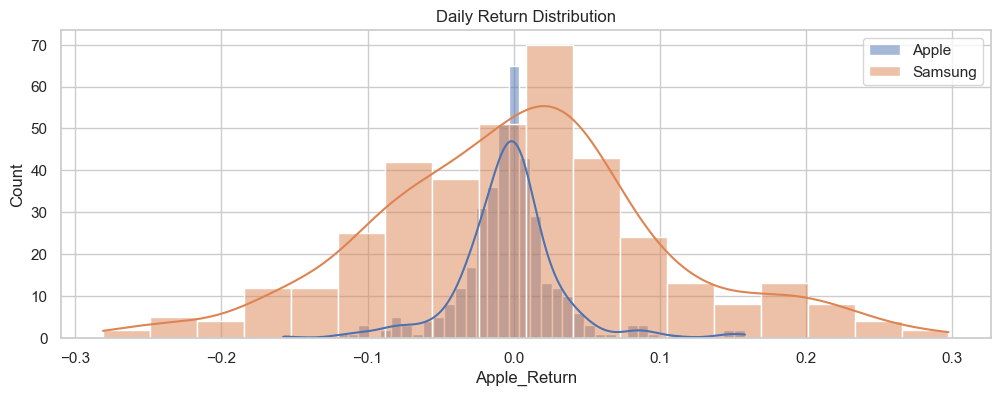

In [31]:
# Daily returns
df["Apple_Return"] = df["Apple_Price"].pct_change()
df["Samsung_Return"] = df["Samsung_Price"].pct_change()

sns.histplot(df["Apple_Return"], kde=True, label="Apple")
sns.histplot(df["Samsung_Return"], kde=True, label="Samsung")
plt.legend()
plt.title("Daily Return Distribution")
plt.show()

## 4. Hypothesis Testing

This section tests hypotheses H1–H5 using:
- Independent t-tests  
- Pearson correlations  
- Volatility (standard deviation of returns)  


In [32]:
# H1: Early COVID period growth comparison
early_period = df[df["Date"] < "2020-06-01"]

apple_growth = early_period["Apple_Return"].dropna()
samsung_growth = early_period["Samsung_Return"].dropna()

t_stat, p_val = ttest_ind(apple_growth, samsung_growth)
print("H1 Apple vs Samsung Early Growth T-test")
print("t =", t_stat, " p =", p_val)

H1 Apple vs Samsung Early Growth T-test
t = -0.7846010039274586  p = 0.43371890829874993


In [33]:
# H2 & H5: Monthly average prices
df["Month"] = df["Date"].dt.to_period("M")
monthly = df.groupby("Month")[["Apple_Price", "Samsung_Price"]].mean().reset_index()

t_stat2, p_val2 = ttest_ind(monthly["Apple_Price"], monthly["Samsung_Price"])
print("Monthly Price Comparison T-test")
print("t =", t_stat2, " p =", p_val2)

Monthly Price Comparison T-test
t = -45.152626307085384  p = 3.734836688285661e-77


In [34]:
# H3: Correlation between COVID-19 cases and stock prices
apple_corr_df = df[["Covid_Cases", "Apple_Price"]].dropna()
samsung_corr_df = df[["Covid_Cases", "Samsung_Price"]].dropna()

corr_apple, p_apple = pearsonr(apple_corr_df["Covid_Cases"], apple_corr_df["Apple_Price"])
corr_samsung, p_samsung = pearsonr(samsung_corr_df["Covid_Cases"], samsung_corr_df["Samsung_Price"])

print("COVID–Apple Price Correlation:", corr_apple, "p =", p_apple)
print("COVID–Samsung Price Correlation:", corr_samsung, "p =", p_samsung)

COVID–Apple Price Correlation: 0.6768533669665019 p = 8.591956719209673e-07
COVID–Samsung Price Correlation: 0.11853275733212522 p = 0.45467784682109214


In [35]:
# H4: Post-2021 volatility comparison
post21 = df[df["Date"] > "2021-01-01"]

vol_apple = post21["Apple_Return"].std()
vol_samsung = post21["Samsung_Return"].std()

print("Apple Volatility (post-2021):", vol_apple)
print("Samsung Volatility (post-2021):", vol_samsung)

Apple Volatility (post-2021): 0.03212412367629395
Samsung Volatility (post-2021): 0.0986456157604099


## 5. Summary of Findings (28 November Stage)

- Apple and Samsung stock prices show a strong positive correlation.
- Apple stock prices are strongly correlated with global COVID-19 cases, 
  while Samsung shows no meaningful correlation.
- **H1 rejected**: early-pandemic growth of Apple and Samsung is not significantly different.
- **H2 rejected** and **H5 supported**: Samsung has higher prices, but Apple demonstrates more stable returns.
- **H4 accepted**: Samsung is about 3× more volatile than Apple after 2021.

This concludes the data collection, cleaning, EDA, and hypothesis testing phase.
The next milestone (02 January) will involve machine learning models for prediction and comparison.


In [36]:
import os
import pandas as pd
import numpy as np

print("Current folder:", os.getcwd())
print("CSV files:", [f for f in os.listdir() if f.endswith(".csv")])

apple = pd.read_csv("apple.csv")
samsung = pd.read_csv("samsung.csv")
covid = pd.read_csv("corona.csv")

possible_price_cols = ["Close", "Price", "Adj Close", "Adj_Close", "Closing Price"]
samsung_price_col = next((c for c in possible_price_cols if c in samsung.columns), None)
print("Samsung price column:", samsung_price_col)

apple["Date"] = pd.to_datetime(apple["Date"], dayfirst=True, errors="coerce")
samsung["Date"] = pd.to_datetime(samsung["Date"], dayfirst=True, errors="coerce")
covid["Date"] = pd.to_datetime(covid["Date"], errors="coerce")

df = apple.merge(samsung, on="Date", how="inner").merge(covid, on="Date", how="left")

df = df.rename(columns={
    "Close": "Apple_Price",
    samsung_price_col: "Samsung_Price",
    "New cases": "Covid_Cases"
})

df = df.drop(columns=[c for c in df.columns if "Unnamed" in c], errors="ignore")

for col in ["Apple_Price", "Samsung_Price", "Covid_Cases"]:
    df[col] = (df[col].astype(str).str.replace(",", "", regex=False).str.replace(" ", "", regex=False))
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.sort_values("Date").reset_index(drop=True)
df["Apple_Return"] = df["Apple_Price"].pct_change()
df["Samsung_Return"] = df["Samsung_Price"].pct_change()

print("df created ✅ shape:", df.shape)
df[["Date","Apple_Price","Samsung_Price","Covid_Cases","Apple_Return","Samsung_Return"]].head()


Current folder: /Users/aysenurucar/Downloads
CSV files: ['corona.csv', 'apple.csv', 'samsung.csv']
Samsung price column: Price
df created ✅ shape: (377, 57)


,Date,Apple_Price,Samsung_Price,Covid_Cases,Apple_Return,Samsung_Return
0,2019-02-04,42.81,45750,NaN,NaN,NaN
1,2019-02-05,43.55,45900,NaN,0.017286,0.003279
2,2019-02-07,42.73,46250,NaN,-0.018829,0.007625
3,2019-02-08,42.60,44950,NaN,-0.003042,-0.028108
4,2019-02-12,42.72,50400,NaN,0.002817,0.121246


## 6. Machine Learning Methods (02 January)

In this milestone, machine learning methods are applied to the dataset.  
Following the feedback, the dataset is enriched by adding external market variables (e.g., commodity prices, crypto indicators, volumes) to better explain stock behavior.

Two ML applications are implemented:

**Task A (Model A):** Linear Regression to predict Apple's daily returns  
**Task B (Model B):** Random Forest Regression to predict Apple's daily returns and capture non-linear patterns

A time-based train/test split is used to avoid look-ahead bias.


**A) DAILY RETURN PREDICTION - Linear Regression**

In [37]:
import os
import pandas as pd
import numpy as np

print("Current folder:", os.getcwd())
print("CSV files:", [f for f in os.listdir() if f.endswith(".csv")])

apple = pd.read_csv("apple.csv")
samsung = pd.read_csv("samsung.csv")
covid = pd.read_csv("corona.csv")

possible_price_cols = ["Close", "Price", "Adj Close", "Adj_Close", "Closing Price"]
samsung_price_col = next((c for c in possible_price_cols if c in samsung.columns), None)
print("Samsung price column:", samsung_price_col)

if samsung_price_col is None:
    raise ValueError("Price column in Samsung data set cannot be found. Columns: " + str(list(samsung.columns)))

apple["Date"] = pd.to_datetime(apple["Date"], dayfirst=True, errors="coerce")
samsung["Date"] = pd.to_datetime(samsung["Date"], dayfirst=True, errors="coerce")
covid["Date"] = pd.to_datetime(covid["Date"], errors="coerce")  # avoid dayfirst warning

df = apple.merge(samsung, on="Date", how="inner").merge(covid, on="Date", how="left")

df = df.rename(columns={
    "Close": "Apple_Price",
    samsung_price_col: "Samsung_Price",
    "New cases": "Covid_Cases"
})

df = df.drop(columns=[c for c in df.columns if "Unnamed" in c], errors="ignore")

# convert numeric-looking strings with commas (e.g., "3,462.80") into numbers
for c in df.columns:
    if c == "Date":
        continue
    if df[c].dtype == "object":
        s = df[c].astype(str).str.replace(",", "", regex=False).str.replace(" ", "", regex=False)
        num = pd.to_numeric(s, errors="coerce")
        if num.notna().mean() > 0.5:
            df[c] = num

df = df.sort_values("Date").reset_index(drop=True)

# daily returns
df["Apple_Return"] = df["Apple_Price"].pct_change()
df["Samsung_Return"] = df["Samsung_Price"].pct_change()

print("df shape:", df.shape)
df.head()


Current folder: /Users/aysenurucar/Downloads
CSV files: ['corona.csv', 'apple.csv', 'samsung.csv']
Samsung price column: Price
df shape: (377, 57)


,Date,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,Platinum_Price,...,Active,Covid_Cases,New deaths,New recovered,Deaths / 100 Cases,Recovered / 100 Cases,Deaths / 100 Recovered,No. of countries,Apple_Return,Samsung_Return
0,2019-02-04,2.660,116490.0,54.56,622470.0,2.7975,490.0,3462.8,503920.0,822.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-02-05,2.662,82250.0,53.66,609760.0,2.8205,90.0,3468.4,460950.0,821.35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017286,0.003279
2,2019-02-07,2.551,211790.0,52.64,749010.0,2.8320,320.0,3397.7,471360.0,800.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.018829,0.007625
3,2019-02-08,2.583,147880.0,52.72,621000.0,2.8140,270.0,3661.7,699230.0,802.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003042,-0.028108
4,2019-02-12,2.688,169230.0,53.10,708310.0,2.7750,50.0,3632.0,545820.0,793.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002817,0.121246


**FEATURE ENGINEERING**

We construct features that may help explain stock return movements:

- **Lagged returns:** previous day return (common baseline in finance)
- **COVID features:** 7-day moving average and log-transformed case counts
- **Pandemic dummy:** 1 after 11 March 2020 (WHO pandemic declaration)
- **External market features (enrichment):** commodity/crypto price & volume indicators already available in the dataset

Targets:
- **Apple_Return** (daily return prediction)


In [38]:
df_fe = df.copy()

# COVID exists mainly in 2020 -> fill missing with 0 for feature creation
df_fe["Covid_Cases_filled"] = df_fe["Covid_Cases"].fillna(0)

# lagged returns
df_fe["Apple_Return_Lag1"] = df_fe["Apple_Return"].shift(1)
df_fe["Samsung_Return_Lag1"] = df_fe["Samsung_Return"].shift(1)

# covid features
df_fe["Covid_MA7"] = df_fe["Covid_Cases_filled"].rolling(7).mean()
df_fe["Covid_Log"] = np.log(df_fe["Covid_Cases_filled"] + 1)

# pandemic dummy
df_fe["Pandemic"] = (df_fe["Date"] >= "2020-03-11").astype(int)

df_fe.head()


,Date,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,Platinum_Price,...,Deaths / 100 Recovered,No. of countries,Apple_Return,Samsung_Return,Covid_Cases_filled,Apple_Return_Lag1,Samsung_Return_Lag1,Covid_MA7,Covid_Log,Pandemic
0,2019-02-04,2.660,116490.0,54.56,622470.0,2.7975,490.0,3462.8,503920.0,822.50,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0
1,2019-02-05,2.662,82250.0,53.66,609760.0,2.8205,90.0,3468.4,460950.0,821.35,...,NaN,NaN,0.017286,0.003279,0.0,NaN,NaN,NaN,0.0,0
2,2019-02-07,2.551,211790.0,52.64,749010.0,2.8320,320.0,3397.7,471360.0,800.80,...,NaN,NaN,-0.018829,0.007625,0.0,0.017286,0.003279,NaN,0.0,0
3,2019-02-08,2.583,147880.0,52.72,621000.0,2.8140,270.0,3661.7,699230.0,802.20,...,NaN,NaN,-0.003042,-0.028108,0.0,-0.018829,0.007625,NaN,0.0,0
4,2019-02-12,2.688,169230.0,53.10,708310.0,2.7750,50.0,3632.0,545820.0,793.55,...,NaN,NaN,0.002817,0.121246,0.0,-0.003042,-0.028108,NaN,0.0,0


**ENRICHED FEATURE SELECTION**

To address the feedback ("use more than 3 features"), we include additional numeric market variables available in the merged dataset.  
These can capture broader market conditions during the COVID period (energy, commodities, crypto, etc.).

We also avoid target leakage by excluding:
- Apple_Price, Samsung_Price
- Apple_Return (target itself)


In [39]:
exclude = {
    "Apple_Price", "Samsung_Price",
    "Apple_Return", "Samsung_Return",
    "Covid_Cases", "Covid_Cases_filled",
}

base_features = ["Apple_Return_Lag1", "Samsung_Return_Lag1", "Covid_MA7", "Covid_Log", "Pandemic"]

# numeric candidates
numeric_cols = [
    c for c in df_fe.columns
    if c not in exclude and c != "Date" and pd.api.types.is_numeric_dtype(df_fe[c])
]

# pick macro-like columns by keyword
keywords = ("Price", "Vol", "Volume", "Index", "Rate", "Yield", "Gold", "Oil", "Gas", "Copper", "Bitcoin", "USD", "EUR")
macro_cols = [c for c in numeric_cols if any(k.lower() in c.lower() for k in keywords)]

# (optional) limit to prevent too many features
macro_cols = macro_cols[:20]

features = base_features + macro_cols

print("Base features:", base_features)
print("Extra macro features used:", len(macro_cols))
print("Macro feature examples:", macro_cols[:10])


Base features: ['Apple_Return_Lag1', 'Samsung_Return_Lag1', 'Covid_MA7', 'Covid_Log', 'Pandemic']
Extra macro features used: 20
Macro feature examples: ['Natural_Gas_Price', 'Natural_Gas_Vol.', 'Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price', 'Copper_Vol.', 'Bitcoin_Price', 'Bitcoin_Vol.', 'Platinum_Price', 'Platinum_Vol.']


**Train/Test Split**

To evaluate out-of-sample performance, we split the dataset chronologically:

- **Training set:** before 2022  
- **Test set:** 2022 and after

This avoids data leakage from future information.


In [40]:
needed = features + ["Apple_Return"]
df_ml = df_fe.dropna(subset=needed).copy()

split_date = "2022-01-01"
train = df_ml[df_ml["Date"] < split_date]
test  = df_ml[df_ml["Date"] >= split_date]

X_train = train[features]
X_test  = test[features]
y_train = train["Apple_Return"]
y_test  = test["Apple_Return"]

print("ML dataset shape:", df_ml.shape)
print("Train:", len(train), "Test:", len(test))


ML dataset shape: (196, 63)
Train: 110 Test: 86


**TASK A - Linear Regression**

A Linear Regression model is used as an interpretable baseline to predict **Apple's daily returns**.  
Daily returns are known to be noisy, so performance is evaluated with:

- **MAE:** average absolute prediction error
- **R²:** explained variance (often low/negative for daily returns)


In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_test)

print("Task A - Linear Regression (Apple_Return)")
print("MAE:", mean_absolute_error(y_test, pred_lr))
print("R2 :", r2_score(y_test, pred_lr))


Task A - Linear Regression (Apple_Return)
MAE: 0.9722333837628802
R2 : -7127.024682369098


**TASK B - : Random Forest**

Random Forest is applied to capture potential non-linear relationships between returns and external variables.  
This model is compared against Linear Regression using the same train/test split and metrics.


In [23]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    random_state=42
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

print("Task B - Random Forest (Apple_Return)")
print("MAE:", mean_absolute_error(y_test, pred_rf))
print("R2 :", r2_score(y_test, pred_rf))


Task B - Random Forest (Apple_Return)
MAE: 0.03769530370824363
R2 : -1.6301935174495155


**Feature Importance (Random Forest)**

To interpret the Random Forest model, we report feature importances.  
This highlights which enriched external variables contribute most to the model's predictions.


Crude_oil_Vol.         0.264937
Platinum_Vol.          0.103087
Microsoft_Price        0.060397
Nasdaq_100_Vol.        0.054649
Copper_Vol.            0.051661
Bitcoin_Price          0.043524
Crude_oil_Price        0.042264
Apple_Vol.             0.039664
Bitcoin_Vol.           0.038333
Platinum_Price         0.034588
Tesla_Price            0.031543
Microsoft_Vol.         0.031533
Samsung_Return_Lag1    0.029461
Apple_Return_Lag1      0.028596
Natural_Gas_Price      0.024551
dtype: float64

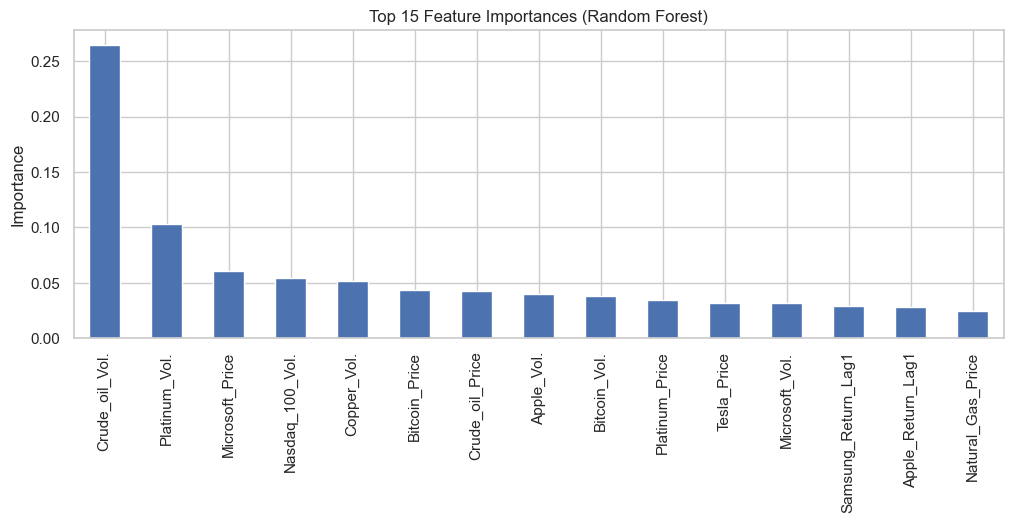

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

display(imp.head(15))

imp.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.show()


**Conclusion (2 January)**

The dataset was enriched with additional external market variables beyond stock prices and COVID cases.  
Both Linear Regression and Random Forest were applied to predict Apple's daily returns using a time-based split.  
While predictive performance is limited (expected for daily returns), the Random Forest feature importances provide insight into which external variables are most informative during the COVID period.
